In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit
import warnings

In [2]:
data = pd.read_csv('downloads/taxi.csv',index_col=[0], parse_dates=[0])
warnings.filterwarnings('ignore', '.*do not.*', )
warnings.warn('Do not show this message')

## Подготовка

In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.sort_index(inplace=True)
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Я прочел данные ,колонку Datetime сделал индексом а колонку num_orders распределил по порядку этих индексов.

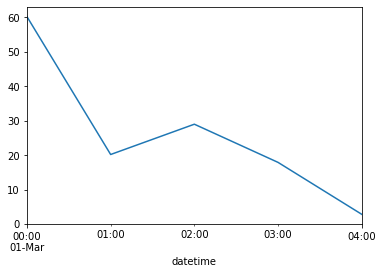

In [6]:
#Хочу проследить сезонность ,для начала посмотрю данные за несколько часов от полуночи и до 4 утра
decomposed = seasonal_decompose(data)
decomposed.seasonal['2018-03-01;00:00:00':'2018-03-01;04:00:00'].plot(ax=plt.gca());

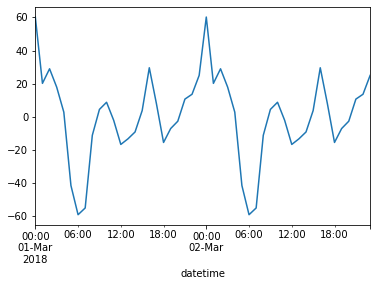

In [7]:
#теперь посмотрю данные за сутки
decomposed = seasonal_decompose(data)
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca());

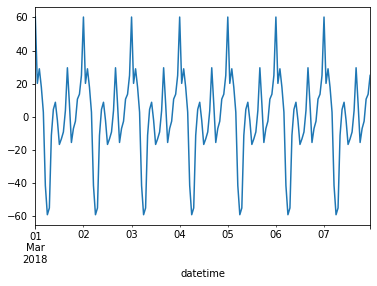

In [8]:
#теперь просмотрю данные за неделю
decomposed.seasonal['2018-03-01':'2018-03-07'].plot(ax=plt.gca());

Судя по графикам,мы имеем дело со стационарным стохастическим процессом.Особенно наглядно это видно по тому,как данные распределяются в сутках.К полуночи у нас пик заказов ,а к 6 вечера у нас самый большой спад.Скорее всего это вызвано тем что в 6 вечера 'час пик' и клиенты предпочитают добираться домой на метро.

In [9]:
#хочу добавить признаки ,а именно Lag,скользящее среднее и колонки по месяцам ,дням и часам
def make_features(data, max_lag,rolling_mean_size):
    data['weekday'] = data.index.weekday
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(window=5).mean()
    return data
make_features(data, 24,24)

data.head()

,num_orders,weekday,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   weekday       4416 non-null   int64  
 2   hour          4416 non-null   int64  
 3   lag_1         4415 non-null   float64
 4   lag_2         4414 non-null   float64
 5   lag_3         4413 non-null   float64
 6   lag_4         4412 non-null   float64
 7   lag_5         4411 non-null   float64
 8   lag_6         4410 non-null   float64
 9   lag_7         4409 non-null   float64
 10  lag_8         4408 non-null   float64
 11  lag_9         4407 non-null   float64
 12  lag_10        4406 non-null   float64
 13  lag_11        4405 non-null   float64
 14  lag_12        4404 non-null   float64
 15  lag_13        4403 non-null   float64
 16  lag_14        4402 non-null   float64
 17  lag_15        4401 non-null

Я решил добавить 24 отстающее значение ,а окно скользящего среднего я установил на уровне 24.

## Обучение

In [11]:
#для начала разобью данные на выборки ,создам функцию для этого
def features(data):
    train,valid = train_test_split(data, shuffle=False, test_size=0.1)
    train = train.dropna()
    valid,test = train_test_split(valid, shuffle=False, test_size=0.5)
    train_X = train.drop(['num_orders'], axis=1)
    train_Y = train['num_orders']
    valid_X = valid.drop(['num_orders'], axis=1)
    valid_Y = valid['num_orders']
    test_X = test.drop(['num_orders'], axis=1)
    test_Y = test['num_orders']
    return train_X,train_Y,valid_X,valid_Y,test_X,test_Y

In [12]:
#теперь напишу функцию для обучения линейной регресии
def regression(train_X,train_Y,valid_X,valid_Y):
    model_regression = LinearRegression().fit(train_X,train_Y)
    predictions_regression = model_regression.predict(valid_X)
    RMSE = mean_squared_error(valid_Y,predictions_regression) ** 0.5
    return RMSE
#теперь напишу функцию для LGBM
def LGBM(train_X,train_Y,valid_X,valid_Y):
    model_LGBM = LGBMRegressor().fit(train_X,train_Y)
    predictions_LGBM = model_LGBM.predict(valid_X)
    RMSE = mean_squared_error(valid_Y,predictions_LGBM) ** 0.5
    return RMSE

In [13]:
feautures_train,target_train,features_valid,target_valid,features_test,target_test = features(data)
regression_rmse = regression(feautures_train,target_train,features_valid,target_valid)
print('Результат RMSE для модели LinearRegression:',regression_rmse)

Результат RMSE для модели LinearRegression: 44.84581005890273


In [14]:
LGBM_rmse = LGBM(feautures_train,target_train,features_valid,target_valid)
print('Результат RMSE для модели LGBM:',LGBM_rmse)

Результат RMSE для модели LGBM: 36.64625021313638


In [15]:
params_test1 = {'max_depth': range(3,8,1), 'num_leaves':range(5, 100, 5)}
tscv = TimeSeriesSplit(n_splits=12)
gsearch1 = GridSearchCV(estimator = LGBMRegressor(
    boosting_type='gbdt',
    objective='regression',metrics='mse',
    learning_rate=0.1, n_estimators=20, 
    max_depth=6, bagging_fraction = 0.8,feature_fraction = 0.8),
                        param_grid = params_test1, cv=tscv,n_jobs=-1,verbose=1
)
gsearch1.fit(feautures_train,target_train)

params_test2={'max_bin': range(5,256,10), 'min_data_in_leaf':range(1,102,10)}

gsearch2 = GridSearchCV(estimator = LGBMRegressor(
    boosting_type='gbdt',objective='regression',metrics='mse',
    learning_rate=0.1, n_estimators=20, max_depth=7,num_leaves = 85, 
    bagging_fraction = 0.8,feature_fraction = 0.8),
                        param_grid = params_test2, cv=tscv,n_jobs=-1,verbose=1
)
gsearch2.fit(feautures_train,target_train)

params_test3={'feature_fraction': [0.6,0.7,0.8,0.9,1.0],
              'bagging_fraction': [0.6,0.7,0.8,0.9,1.0],
              'bagging_freq': range(0,81,10)
}
              
gsearch3 = GridSearchCV(estimator = LGBMRegressor(
    boosting_type='gbdt',objective='regression',metrics='mse',
    learning_rate=0.1, n_estimators=20, max_depth=7,num_leaves = 85,max_bin = 195,min_data_in_leaf = 1, 
    bagging_fraction = 0.8,feature_fraction = 0.8),
                        param_grid = params_test3, cv=tscv,n_jobs=-1,verbose=1
)
gsearch3.fit(feautures_train,target_train)
              
print(gsearch1.best_params_)
print(gsearch2.best_params_)
print(gsearch3.best_params_)

Fitting 12 folds for each of 95 candidates, totalling 1140 fits
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
Fitting 12 folds for each of 286 candidates, totalling 3432 fits
Fitting 12 folds for each of 225 candidates, totalling 2700 fits
{'max_depth': 7, 'num_leaves': 75}
{'max_bin': 55, 'min_data_in_leaf': 11}
{'bagging_fraction': 0.6, 'bagging_freq': 0, 'feature_fraction': 0.6}


In [16]:
#попробую улучшенную модель
def LGBM_2(train_X,train_Y,valid_X,valid_Y):
    model_LGBM = LGBMRegressor(max_depth=7,num_leaves=75,max_bin=55,
                              min_data_in_leaf=11,bagging_fraction=0.9,
                              bagging_freq=0,feature_fraction=0.6).fit(feautures_train,target_train)
    predictions_LGBM = model_LGBM.predict(valid_X)
    RMSE = mean_squared_error(valid_Y,predictions_LGBM) ** 0.5
    return RMSE

def LGBM_preds(train_X,train_Y,valid_X,valid_Y):
    model_LGBM = LGBMRegressor(max_depth=7,num_leaves=75,max_bin=55,
                              min_data_in_leaf=11,bagging_fraction=0.9,
                              bagging_freq=0,feature_fraction=0.6).fit(feautures_train,target_train)
    predictions_LGBM = model_LGBM.predict(valid_X)
    return predictions_LGBM

LGBM_rmse_2 = LGBM_2(feautures_train,target_train,features_valid,target_valid)
print('Показатели RMSE улучшенной модели:',LGBM_rmse_2)
if LGBM_rmse_2 < LGBM_rmse:
    print('Модель улучшилась!')
else:
    print('Что-то пошло не так!!!')

Показатели RMSE улучшенной модели: 35.962422004426784
Модель улучшилась!


На данном этапе модель LGBM показывает хороший результат,считаю целесообразным выбрать ее для финального тестирования

## Тестирование

In [17]:
#для тестирования я отобрал модель LGBM
LGBM_FINAL = LGBM_2(feautures_train,target_train,features_test,target_test)
print('Финальный результат RMSE для модели LGBM на тестовой выборке:',LGBM_FINAL)

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
Финальный результат RMSE для модели LGBM на тестовой выборке: 42.96893084834736


In [18]:
#напишу функциии для моего финального графика работы модели
#функция для исторических и предсказанных данных
def predictions(X_train,Y_train,X_test,Y_test):
    model = LGBMRegressor(max_depth=7,num_leaves=75,max_bin=55,
                              min_data_in_leaf=11,bagging_fraction=0.9,
                              bagging_freq=0,feature_fraction=0.6).fit(X_train,Y_train)
    predictions = model.predict(X_test)
    preds = pd.Series(predictions)
    Y_test = pd.DataFrame(Y_test).reset_index()
    data_final = pd.merge(Y_test,preds.rename('predictions'), how = 'left', left_index=True, 
                      right_index=True).set_index('datetime')
    x = data_final['num_orders']
    y = data_final['predictions']
    return x,y
#функция для графика
def plot(x,y,title):
    plt.plot(x, label='исторические данные')
    plt.plot(y, label='предсказанные данные')
    plt.legend(loc='upper right')
    plt.title(title)
    plt.plot(figsize=(40, 40))
    plt.xticks(rotation=45)
    return plt.show();

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


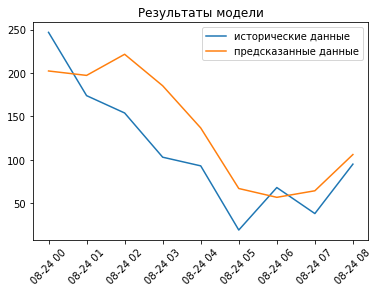

In [19]:
#вывожу график
x,y = predictions(feautures_train,target_train,features_test,target_test)
chart = plot(x['2018-08-24;00:00:00':'2018-08-24;08:00:00'],y['2018-08-24;00:00:00':'2018-08-24;08:00:00'],'Результаты модели')

### Вывод

Модель LGBM на финальном тестировании показала результат 42.96893084834736.На нрафике 'Результаты модели' хорошо видно как предсказанные значения отличаются от исторических данных.Я специально взял небольшой промежуток времени в 8 часов для наглядности.